#Initialize Functions to Generate Outputs

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.cluster import normalized_mutual_info_score

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
def plot_reconstruction(model, n=24):
    x,_ = next(iter(data_loader))
    x = x[:n,:,:,:].to(device)
    try:
        out, _, _, log_p = model(x.view(-1, image_size)) 
    except:
        out, _, _ = model(x.view(-1, image_size)) 
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
    out_grid = torchvision.utils.make_grid(x_concat).cpu().data
    show(out_grid)

def plot_reconstructionG(model, l_onehot, n=24):
    x,_ = next(iter(data_loader))
    x = x[:n,:,:,:].to(device)
    try:
        out, _, _, log_p = model(x.view(-1, image_size), l_onehot) 
    except:
        out, _, _ = model(x.view(-1, image_size)) 
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
    out_grid = torchvision.utils.make_grid(x_concat).cpu().data
    show(out_grid)
def plot_generation(model, n=24):
    with torch.no_grad():
        z = torch.randn(n, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

def plot_conditional_generation(model, n=8, fix_number=None):
    with torch.no_grad():
        matrix = np.zeros((n,n_classes))
        matrix[:,0] = 1

        if fix_number is None:
            final = matrix[:]
            for i in range(1,n_classes):
                final = np.vstack((final,np.roll(matrix,i)))
            #z = torch.randn(8*n_classes, z_dim).to(device)
            z = torch.randn(8, z_dim)
            z = z.repeat(n_classes,1).to(device)
            y_onehot = torch.tensor(final).type(torch.FloatTensor).to(device)
            out = model.decode(z,y_onehot).view(-1, 1, 28, 28)
        else:
            z = torch.randn(n, z_dim).to(device)
            y_onehot = torch.tensor(np.roll(matrix, fix_number)).type(torch.FloatTensor).to(device)
            out = model.decode(z,y_onehot).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

# Initialize Device and Read Data

## Initialize Devices


In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Read Data

In [ ]:
batch_size = 128

data_dir = 'data'
# MNIST dataset
dataset = torchvision.datasets.MNIST(root=data_dir,
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

#Create Model Architecture

In [ ]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 25
learning_rate = 1e-3

# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model1 = VAE().to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate)

model2 = VAE().to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)

model3 = VAE().to(device)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=learning_rate)



# Beta Optimizer VAE Training

In [ ]:
from mpmath import *
import random
beta_values = []
run = []
# Number of arm or value ranges
d = 10

# Parameters for n arm bandit 
arm_selected = []
numbers_of_selections = [0] * d 
sums_of_reward = [0] * d
arm = 0
# Simulated anneling parameters
# for each arm we will save those values
arm_best = [0] * d
arm_current = [0] * d
arm_best_reward = [0] * d
arm_current_reward = [0] * d
candidate = 0 
candidate_reward = 0
step_size_list = [0] * d
temp = 10
pre_loss = 0
pre_loss_per_arm = [0] * d
#Define search space for each arms
beg_list = []
end_list = []
search_domain = 10
search_range = search_domain/d
start = 1
end = 0
for i in range(0,d-1):
  beg_list.append(start)
  end = start + search_range
  end_list.append(end)
  start += search_range
beg_list.append(start)
end_list.append(search_domain*2)
print(step_size_list)
# Define step sizes for first d-1 arm and last arm. last arm will have different 
# range than the first arm
for i in range(0,d-1):
  step_size_list[i] = (end_list[i] - beg_list[i]) * 0.25
step_size_list[d-1] = (end_list[d-1] - beg_list[d-1]) * 0.25

# Initialize arm best based on their limit, their middle point
for i in range(0,d):
  arm_best[i] = (beg_list[i] + end_list[i])/2
arm_generation = 1
n = 0
c = 0
epoch_count = 0
epoch_counts = []
epoch_betas = []
epoch_loss = []
epoch_loss_main = []
iteration_loss = []
#*****
iteration_betas = []
total_couns = []
for epoch in range(num_epochs):
    epoch_beta = []
    for i, (x, _) in enumerate(data_loader):
        with torch.autograd.set_detect_anomaly(True):
          # Forward pass
          x = x.to(device).view(-1, image_size)
          x_reconst, mu, log_var = model1(x)
          
          # Compute reconstruction loss and kl divergence
          # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
          # https://arxiv.org/abs/1606.05908
          reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
          kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

          if (arm_generation == 1):
            # Select the arm, n arm bandit using UCB
            max_upper_bound = 0
            for i in range(0, d):
                if (numbers_of_selections[i] > 0):
                    average_reward = sums_of_reward[i] / numbers_of_selections[i]
                    delta_i = math.sqrt(2 * math.log(n+1) / numbers_of_selections[i])
                    upper_bound = average_reward + delta_i
                else:
                    upper_bound = 1e400
                if upper_bound > max_upper_bound:
                    max_upper_bound = upper_bound
                    arm = i
            arm_selected.append(arm)
            numbers_of_selections[arm] += 1
            print(arm)
          print(i)
          # search a beta value in arm's search space using simulated anneling
          if(numbers_of_selections[arm] == 1):
            # we will use the loss function here =
            reward = reconst_loss + arm_best[arm]*kl_div
            arm_best_reward[arm] = 1/ reward
            arm_current[arm] = arm_best[arm]
            arm_current_reward[arm] = arm_best_reward[arm]
            sums_of_reward[arm] += arm_best_reward[arm]
            pre_loss = reward
            pre_loss_per_arm[arm] = reward
            iteration_loss.append(pre_loss)
            optimizer1.zero_grad()
            reward.backward(retain_graph=False)
            optimizer1.step()

          else:
            
            
            if arm_generation == 1:
              step_size = step_size_list[arm]
              step_size_list[arm] = step_size - step_size * 0.05
              candidate = arm_current[arm] + np.random.normal() * step_size
              candidate_reward_loss = reconst_loss + candidate*kl_div
              optimizer1.zero_grad()
              iteration_loss.append(candidate_reward_loss)
              candidate_reward_loss.backward(retain_graph=False)
              optimizer1.step()
              arm_generation = 0
              
            
            else:
              new_loss = 1/(reconst_loss + candidate*kl_div)
              iteration_loss.append(new_loss)
              candidate_reward = (1/candidate_reward_loss) - (1/pre_loss)
              # check for new best solution
              if new_loss > arm_best_reward[arm]:
                # store new best point
                arm_best[arm], arm_best_reward[arm] = candidate, new_loss

              # difference between candidate and current point evaluation
              diff = candidate_reward - arm_current_reward[arm]
              # calculate temperature for current epoch
              t = temp / float(n + 1)
            
              # calculate metropolis acceptance criterion
              #try:
              #  metropolis = exp(-diff / t)
              #except OverflowError:
              #  metropolis = float('inf')
              # check if we should keep the new point
              if diff < 0 or np.log(np.random.rand())*t < diff:
                # store the new current point
                arm_current[arm], arm_current_reward[arm] = candidate, new_loss
              # calculate the reward, we will consider the best reward from each arm, not 
              # the exploration arm, this way our loss function within the arm will remain
            
            
              #consistant
              pre_loss = new_loss
              pre_loss_per_arm[arm] = new_loss
              reward = 1/pre_loss - 1/arm_current_reward[arm]
              sums_of_reward[arm] += candidate_reward
              #loss = arm_best_reward[arm]
              arm_generation = 1
            
            #beta = random.randint(beg_list[arm], end_list[arm])
          beta_values.append(arm_current[arm])
          epoch_beta.append(arm_current[arm])
          iteration_betas.append(arm_current[arm])
          # Backprop and optimize
          #loss = reconst_loss + candidate * kl_div
          #pre_loss = loss
          #print(loss)
          #sums_of_reward[arm] += 1/loss
          
          #optimizer.zero_grad()
          #loss.backward(retain_graph=False)
          #optimizer.step()
          total_couns.append(c)
          c += 1

        n += 1    
        run.append(n)
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size, kl_div.item()/batch_size))
    epoch_count += 1
    epoch_counts.append(epoch_count)
    epoch_betas.append(sum(iteration_betas)/len(iteration_betas))
    torch.cuda.empty_cache()
    epoch_loss_main.append(sum(iteration_loss)/len(iteration_loss))
    


Streaming output truncated to the last 5000 lines.
9
Epoch[20/25], Step [10/469], Reconst Loss: 142.1418, KL Div: 3.9955
384
8
9
Epoch[20/25], Step [10/469], Reconst Loss: 147.3286, KL Div: 4.1720
386
8
9
Epoch[20/25], Step [10/469], Reconst Loss: 140.7021, KL Div: 4.0002
388
8
9
Epoch[20/25], Step [10/469], Reconst Loss: 148.1332, KL Div: 4.1464
390
8
9
Epoch[20/25], Step [10/469], Reconst Loss: 148.3616, KL Div: 4.1218
392
8
9
Epoch[20/25], Step [10/469], Reconst Loss: 138.3914, KL Div: 4.1875
394
8
9
Epoch[20/25], Step [10/469], Reconst Loss: 142.6860, KL Div: 4.1699
396
8
9
Epoch[20/25], Step [10/469], Reconst Loss: 143.7518, KL Div: 4.0756
398
8
9
Epoch[20/25], Step [10/469], Reconst Loss: 140.2491, KL Div: 4.1491
400
8
9
Epoch[20/25], Step [10/469], Reconst Loss: 142.7719, KL Div: 4.0480
402
8
9
Epoch[20/25], Step [10/469], Reconst Loss: 138.0460, KL Div: 4.2127
404
8
9
Epoch[20/25], Step [10/469], Reconst Loss: 145.8797, KL Div: 4.3305
406
8
9
Epoch[20/25], Step [10/469], Recons

# Beta Optimizer VAE Outputs


## Beta Value Update for Epochs

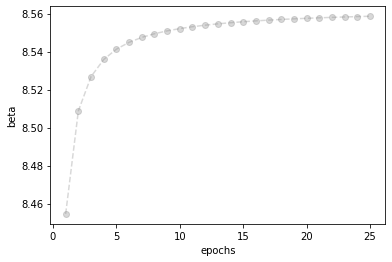

In [ ]:

import matplotlib.pyplot as plt
plt.plot(epoch_counts, epoch_betas, 'o--', color='grey', alpha=0.3)
plt.xlabel('epochs')
plt.ylabel('beta')
plt.show()

## Beta Value Update for Iterations

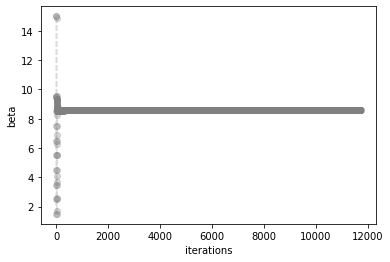

In [ ]:
import matplotlib.pyplot as plt
plt.plot(total_couns, iteration_betas, 'o--', color='grey', alpha=0.3)
plt.xlabel('iterations')
plt.ylabel('beta')
plt.show()

## Reconstruction of Images using Beta Optimizer VAE

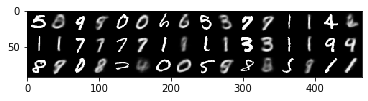

In [ ]:
plot_reconstruction(model1)

## Generation of Images using Beta Optimizer VAE


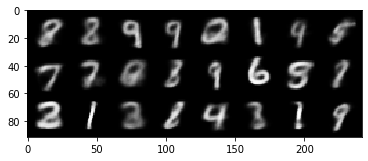

In [ ]:
plot_generation(model1)

# Normal VAE Training

In [ ]:
##EDITED BY Abhijit
## Code for the baseline


epoch_loss_vae = []
iteration_loss_vae = []
for epoch in range(25):
    epoch_loss = []
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model2(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
        # https://arxiv.org/abs/1606.05908
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        print(loss)
        optimizer2.zero_grad()
        loss.backward(retain_graph=False)
        optimizer2.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size, kl_div.item()/batch_size))
            
        iteration_loss_vae.append(loss)
    torch.cuda.empty_cache()
    epoch_loss_vae.append(sum(iteration_loss_vae)/len(iteration_loss_vae))

Streaming output truncated to the last 5000 lines.
tensor(13457.4668, grad_fn=<AddBackward0>)
tensor(13206.5449, grad_fn=<AddBackward0>)
tensor(13144.9980, grad_fn=<AddBackward0>)
Epoch[16/25], Step [140/469], Reconst Loss: 77.5214, KL Div: 25.1739
tensor(13468.9316, grad_fn=<AddBackward0>)
tensor(13552.2598, grad_fn=<AddBackward0>)
tensor(13062.9297, grad_fn=<AddBackward0>)
tensor(13831.3428, grad_fn=<AddBackward0>)
tensor(13210.3154, grad_fn=<AddBackward0>)
tensor(13387.6699, grad_fn=<AddBackward0>)
tensor(13280.8027, grad_fn=<AddBackward0>)
tensor(13702.1602, grad_fn=<AddBackward0>)
tensor(13141.0156, grad_fn=<AddBackward0>)
tensor(12977.0322, grad_fn=<AddBackward0>)
Epoch[16/25], Step [150/469], Reconst Loss: 76.3512, KL Div: 25.0318
tensor(13462.9648, grad_fn=<AddBackward0>)
tensor(13229.2988, grad_fn=<AddBackward0>)
tensor(13339.3350, grad_fn=<AddBackward0>)
tensor(13870.9717, grad_fn=<AddBackward0>)
tensor(13210.3232, grad_fn=<AddBackward0>)
tensor(13460.9902, grad_fn=<AddBackwa

# Normal VAE Outputs

## Image Reconstruction Using Normal VAE

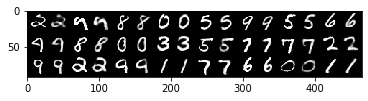

In [ ]:
plot_reconstruction(model2)

## Image Generation using Normal VAE

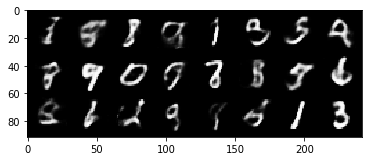

In [ ]:
plot_generation(model2)

# Random Beta VAE Training where Beta = 15

In [ ]:
epoch_loss_beta_vae = []
iteration_loss_beta_vae = []
for epoch in range(25):
    epoch_loss = []
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model3(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
        # https://arxiv.org/abs/1606.05908
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + 15 * kl_div
        print(loss)
        optimizer3.zero_grad()
        loss.backward(retain_graph=False)
        optimizer3.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size, kl_div.item()/batch_size))
            
        iteration_loss_beta_vae.append(loss)
    torch.cuda.empty_cache()
    epoch_loss_beta_vae.append(sum(iteration_loss_beta_vae)/len(iteration_loss_beta_vae))

Streaming output truncated to the last 5000 lines.
tensor(25590.4160, grad_fn=<AddBackward0>)
tensor(24558.8184, grad_fn=<AddBackward0>)
tensor(25673.3984, grad_fn=<AddBackward0>)
Epoch[16/25], Step [140/469], Reconst Loss: 173.5879, KL Div: 1.7990
tensor(25233.5098, grad_fn=<AddBackward0>)
tensor(24240.6953, grad_fn=<AddBackward0>)
tensor(24908.2988, grad_fn=<AddBackward0>)
tensor(25066.9609, grad_fn=<AddBackward0>)
tensor(25805.7344, grad_fn=<AddBackward0>)
tensor(24737.2852, grad_fn=<AddBackward0>)
tensor(25144.1270, grad_fn=<AddBackward0>)
tensor(25369.2734, grad_fn=<AddBackward0>)
tensor(25701.2930, grad_fn=<AddBackward0>)
tensor(25856.5898, grad_fn=<AddBackward0>)
Epoch[16/25], Step [150/469], Reconst Loss: 173.9104, KL Div: 1.8729
tensor(25308.3750, grad_fn=<AddBackward0>)
tensor(25587.0273, grad_fn=<AddBackward0>)
tensor(25174.4121, grad_fn=<AddBackward0>)
tensor(25352.2910, grad_fn=<AddBackward0>)
tensor(24232.0547, grad_fn=<AddBackward0>)
tensor(25631.7168, grad_fn=<AddBackwa

# Random Beta VAE Outputs

## Image Reconstruction using Random Beta VAE Training where Beta = 15

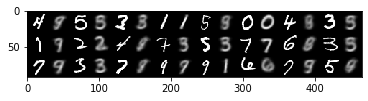

In [ ]:
plot_reconstruction(model3)

# Image Generation using Random Beta VAE Training where Beta = 15

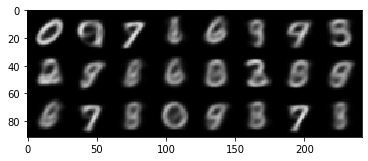

In [ ]:
plot_generation(model3)

# Loss Comparison of Three Models

## Loss Dataset Creation

In [ ]:
import pandas as pd
df = pd.DataFrame()
losses = []
for loss in epoch_loss_main:
  losses.append(loss.detach().numpy())
df['Loss_Beta_optimizer'] = losses
losses = []
for loss in epoch_loss_vae:
  losses.append(loss.detach().numpy())
df['Loss_vae'] = losses

losses = []
for loss in epoch_loss_beta_vae:
  losses.append(loss.detach().numpy())

df['Loss_beta_vae'] = losses
df.to_csv('Losses.csv',index =False)

## Plot Losses

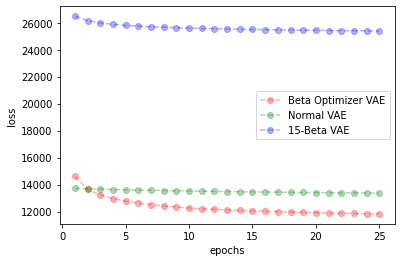

In [ ]:
import matplotlib.pyplot as plt2
plt2.plot(epoch_counts, df['Loss_Beta_optimizer'], 'o--', color='red', alpha=0.3)
plt2.plot(epoch_counts, df['Loss_vae'], 'o--', color='green', alpha=0.3)
plt2.plot(epoch_counts, df['Loss_beta_vae'], 'o--', color='blue', alpha=0.3)
plt2.xlabel('epochs')
plt2.ylabel('loss')
location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Beta Optimizer VAE", "Normal VAE", "15-Beta VAE"], loc=0, frameon=legend_drawn_flag)
plt2.show()